# Objective
The goal of this personalization project will be to maximize the accuracy of our recommendation system when considering the results of recommending the top-5 movies for a given user using MovieLens' 10M ratings dataset.

Background: MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using CF of members' movie ratings and reviews. To address the cold-start problem for new users, MovieLens uses preference elicitation where they ask new users to rate how much they enjoy watching different genres of movies.

The dataset contains 10000054 ratings. Users were selected at random but all users selected had rated at least 20 movies. The data contains three files: 

#### 1. Movies.dat
Each line of this file represents one movie, and has the following format: MovieID::Title::Genres
MovieID is the real MovieLens id.

Movie titles, by policy, should be entered identically to those found in IMDB, including year of release. However, they are entered manually, so errors and inconsistencies may exist.

Genres are a pipe-separated list, and are selected from the following:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western


#### 2. Ratings.dat
All ratings are contained in the file ratings.dat. Each line of this file represents one rating of one movie by one user, and has the following format:

UserID::MovieID::Rating::Timestamp

The lines within this file are ordered first by UserID, then, within user, by MovieID.

Ratings are made on a 1-5 star scale, with half-star increments.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


#### 3. Tags.dat
All tags are contained in the file tags.dat. Each line of this file represents one tag applied to one movie by one user, and has the following format:

UserID::MovieID::Tag::Timestamp

The lines within this file are ordered first by UserID, then, within user, by MovieID.

Tags are user generated metadata about movies. Each tag is typically a single word, or short phrase. The meaning, value and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.



# 1. Item-Based Collaborative Filtering Algorithm

The general methodology we used to create an item-based collaborative filtering algorithm is as follows
1. Define a set of mutually observed users that have specified ratings for movie i and j 
2. Compute similarity between movie i and movie j using Pearson's correlation
3. Find top k matching items to movie i for which user u has specified ratings. The weighted average of these ratings is reported as the predicted rating value of that particular item.

Our objective is to maximize the accuracy of the top 5 movie recommendations users would enjoy out of those they have not seen yet. To do this we will use an approach that is similar to weighted KNN. 

In [1]:
import pandas as pd

moviescol = ['MovieId', 'Title', 'Genres','Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

ratings = pd.read_csv('./ratings.dat', sep = '::', names = ['UserId', 'MovieId', 'Rating', 'Timestamp'], engine = 'python')
movies = pd.read_csv('./movies.dat', sep ='::', names = moviescol, engine='python')

In order to determine the most appropriate way to sample our data, we first need to get a better understanding of the sparsity level of the user-item matrix. As seen in the introduction paper of item-based CF, we can calculate the Sparsity level of a matrix by using 1- (nonzero entries/total entries) 

In [2]:
# Compute the Sparsity of the Matrix by first finding the number of unique items and users present in the ratings df. Although the Movielens site already provides us with number of unique movies and usrs information, we provide a procedure to obtain it regardless.

n_users = ratings['UserId'].nunique()
n_items = ratings['MovieId'].nunique()

print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

sparsity = round(1.0-len(ratings)/float(n_users*n_items),3)
print 'The sparsity level of MovieLens10M is ' +  str(sparsity*100) + '%'

Number of users = 69878 | Number of movies = 10677
The sparsity level of MovieLens10M is 98.7%


Next we'll load a python file in which we define all of our useful functionality. See `funcs.py` in the repository for the source. We use the surprise library for building and training the KNN model. 


In [ ]:
# %load 'funcs.py'
import surprise as sp
from surprise import AlgoBase
import pandas as pd
import numpy as np
from sklearn import cross_validation as cv
import funcs as F
import itertools as it

def build_movie_genre_matrix(movies):
    """
    Build a NxM matrix, rows are movie_ids, columns are genres, values 0, 1
    @param movies Dataframe dataframe of movie data
    @returns Matrix like Dataframe with 0s and 1s filled in 
    """
    movie_genre = []
    for (idx, row) in movies.iterrows(): 
        genres = row.loc['Genres'].split("|")
        movieid = row.loc['MovieId']
        for g in genres:  
            movie_genre.append({'MovieId': movieid, 'Genre': g})

    moviegenrecol = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    test = pd.DataFrame(0, index = np.arange(len(movies)), columns = moviegenrecol)
    MovieGenres = pd.concat([movies['MovieId'], test], axis = 1)
    MovieGenres.columns= ['MovieId','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    for row in movie_genre: 
        movieID = row['MovieId']
        genre = row['Genre']
        MovieGenres.loc[MovieGenres.MovieId == movieID, genre] = 1

    return MovieGenres

        
def build_user_item_matrix(ratings):
    """
    Return a USERxITEM matrix with values as the user's value for the movie, null otherwise
    Right now not normalized
    @param ratings Dataframe
    @returns matrix numpy matrix with a user's ratings per movie
    """
    matrix = ratings.pivot(index = 'UserId', columns = 'MovieId', values = 'Rating').fillna(0)
    return matrix

def sample(ratings, user_counts, movie_counts, n, m):
    """
    Return a smaller matrix with top n users and top m items only
    @param ratings the ratings dataset 
    @param user_counts Count values of user ratings
    @param movie_counts Movie count values
    @param n number of users with most ratings
    @param m number of movies with most ratings
    @returns NxM matrix of USERxITEM ratings
    """
    n_users = ratings['UserId'].nunique()
    n_items = ratings['MovieId'].nunique()

    user_sample = user_counts.head(n).index
    movie_sample = movie_counts.head(m).index

    print len(user_sample)
    print len(movie_sample)

    subset = ratings.loc[ratings['UserId'].isin(user_sample)].loc[ratings['MovieId'].isin(movie_sample)]
    # we don't need the timestamp
    del subset['Timestamp']
    return subset


# define our own baseline algorithm that Surprise can use. Just predict the average!
class AvgBase(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    # see Surprise#building_custom_algo
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        # remember DF is uid, iid, rating
        self.mean = np.mean([rating for (_, _, rating) in self.trainset.all_ratings()])

    def estimate(self, u, i):
        return self.mean


def normalize_user_means(ratings):
    """
    @param Ratings pandas dataframe
    @returns user mean normalized dataframe
    """
    u_i_df = F.build_user_item_matrix(ratings)
    means = u_i_df.mean(axis=1)

    def f(row):
        u_id = row["UserId"]
        new_r = row["Rating"] - means[u_id]
        return new_r

    ratings['Rating'] = ratings.apply(f, axis = 1)
    return ratings
    

# we need something to test our model against. Use above defined model.
def train_baseline(ratings):
    """
    Baseline model. Same as below, return a model and data to test it on
    @param ratings Pandas Dataframe with UserId, MovieId, Ratings
    @returns Tuple (algorithm, testdata) basemodel that just returns the baseline estimate for user/item (adjusted for user bias)
    """
    train_data, test_data = cv.train_test_split(ratings, test_size = 0.20)

    algo = AvgBase()
    reader = sp.Reader(rating_scale=(1, 5))

    trainset = sp.Dataset.load_from_df(ratings, reader)
    testset = sp.Dataset.load_from_df(test_data, reader)

    trainset = trainset.build_full_trainset()

    algo.train(trainset)

    testset = testset.build_full_trainset().build_testset()
    return (algo, testset)



# train the KNN model on subsets of the data (for cross-validation)
def train(ratings, k_neighbors, k_folds):
    """
    Train a model and return it. Then we can use the model and evaluate it elsewhere
    @param ratings dataframe pandas dataframe to train on, with columns UserId, MovieId, Ratings
    @param k_neighbors number of neighbors to examine
    @param k_folds number of folds for cross validation
    @returns List of (algo, test data)
    We can call methods such as `test` and `evaluate` on this object 
    """

    train_data, test_data = cv.train_test_split(ratings, test_size = 0.20)
    reader = sp.Reader(rating_scale=(1, 5))

    trainset = sp.Dataset.load_from_df(train_data, reader)
    testset = sp.Dataset.load_from_df(test_data, reader)

    trainset.split(n_folds = k_folds)

    similarity_options = { 'name': 'pearson', 'user_based': False }
    algo = sp.KNNWithMeans(sim_options = similarity_options, k = k_neighbors, min_k = 5)

    for _trainset, _ in trainset.folds():
        algo.train(_trainset)


    testset = testset.build_full_trainset().build_testset()
    return (algo, testset)

def train_matrix(ratings, factor, k_folds):
    """
    Train a model and return it. Then we can use the model and evaluate it elsewhere
    @param ratings dataframe pandas dataframe to train on, with columns UserId, MovieId, Ratings
    @param n_folds number of folds for cross validation
    @returns List of (algo, test data)
    We can call methods such as `test` and `evaluate` on this object 
    """

    train_data, test_data = cv.train_test_split(ratings, test_size = 0.20)
    reader = sp.Reader(rating_scale=(1, 5))

    trainset = sp.Dataset.load_from_df(train_data, reader)
    testset = sp.Dataset.load_from_df(test_data, reader)
    trainset.split(n_folds = k_folds)

    algo = sp.SVD(n_factors = factor)

    for trainset, _ in trainset.folds():
        algo.train(trainset)
        
    testset = testset.build_full_trainset().build_testset()
    return (algo, testset)


def group_predictions_by_user(predictions):
    """
    @param List of Surprise predictions objects
    @returns Dict {uid: [P1, P2, ...PN]} hash mapping user id to top n predictions
    """
    p = sorted(predictions, key = lambda x: x.uid)

    groups = {}
    for k, g in it.groupby(p, lambda x: x.uid):
        groups[k] = sorted(list(g), key = lambda x: x.est, reverse = True)

    return groups


# For every item that a user would be rated, in top k
def calculate_catalog_coverage(ratings, predictions, k):
    """
    Calculate the catalog coverage of a model over a dataset
    @param ratings pandas dataframe with UserId, MovieId, Ratings. Must be the same set the model was trained on
    @param List Surprise predictions
    @oaram k Int the top k recommendations size
    @returns Float percentage of items recommended to at least one user
    """
    n_movies = ratings['MovieId'].nunique()

    movies_reccommended = set() # keep track of which movies are recommended. Note we only care about the number

    recommendations = group_predictions_by_user(predictions)
    for u_id, recs in recommendations.iteritems():
        movies_reccommended.update(map(lambda x: x.iid, recs[0:3]))

    return len(movies_reccommended) / float(n_movies)


# print some evaluative summaries
def evaluate(algo, ratings, testset, top_k = 5):
    """
    @param algo Surprise algorithm the model that was trained
    @oaram ratings The ratings it was trained on, in pandas Dataframe form (so we can calculate coverage)
    @param testset Surprise testset object, the data held out during cross-validation
    @returns Nested Dictionary {test: {rmse, mae}, train: {rmse, mae, cc}}
    We can use these to build up arrays for plotting.
    """

    ret = {}
    ret['test'] = {}
    ret['train'] = {}

    test_predictions = algo.test(testset)
    # see how it would do on the trainset to compare, comes with the algo object
    trainset = algo.trainset.build_testset()
    train_predictions = algo.test(trainset)

    # sticking evaluate in everything for grep, training is verbose
    ret['test']['rmse'] = sp.accuracy.rmse(test_predictions)
    ret['train']['rmse'] = sp.accuracy.rmse(train_predictions)

    ret['test']['mae'] = sp.accuracy.mae(test_predictions)
    ret['train']['mae'] = sp.accuracy.mae(train_predictions)

    # Hackish, baseline does not have a sense of "neighbors"
    knn = algo.__module__ = "surprise.prediction_algorithms.knns"
    mf =  algo.__module__ = "surprise.prediction_algorithms.matrix_factorization"

    if (knn or mf):
        ret['test']['cc'] = calculate_catalog_coverage(ratings, test_predictions, top_k)

    return ret




# matrix = funcs.build_user_item_matrix(ratings, movies)


Given that we want to work with a sample size of 10000 users and 100 items to start with, we cannot sample at random due to the high sparsity level of 98.7% previously calculated. Therefore we will obtain the top 10000 users with the most ratings and the most rated 100 movies. Funcs.py defines just such a sampling function, taking the top n users with the most ratings and the top-m most rated movies.

In [11]:
user_counts = ratings['UserId'].value_counts()
movie_counts = ratings['MovieId'].value_counts()

subset = sample(ratings, user_counts, movie_counts, 10000, 100)

And then we can train our model using a function defined above. `train(data, k_neighbors, k_folds)` handles splitting the data into train and test sets, and folds for cross validation. This function trains our model, and then returns to us a tuple containing the (model, testdata) i.e. the model and the 20% of test data that we have withheld, so that way can test it and do what we like with the predictions. 

The library calculates mean centered Pearson correlation under the hood. Conceptually, it is simply mean centering all of the items, and computing the pairwise similarity for each, based on user ratings. This is the slowest part of the model, running in `O(nm^2)` time, where m is the number of items and n is the number of users. This is the reason that item-based methods are more tractable than user-based methods; the number of items is usually far less than the number of users. `nm^2` is still pretty big, but since this gets run offline that's alright, as long as it runs on the order of hours rather than weeks.

In [12]:
model, testdata = train(subset, 10, 5)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


Now we can evaluate our model. The function defined above `evaluate(algo, rating, testset, top_k=5)` takes the trained model, the original dataset, a testset, and the number of top-k recs and comptues some useful summaries about our model. Specifically it returns a hash with RMSE, MAE for test and train sets, and catalog coverage for the test set. 

In [13]:
evaluation = evaluate(model, subset, testdata)

RMSE: 0.8508
RMSE: 0.5245
MAE:  0.6501
MAE:  0.4068


In [14]:
print evaluation

{'test': {'cc': 0.99, 'mae': 0.65010674683631375, 'rmse': 0.85077590085280186}, 'train': {'mae': 0.40683865954621445, 'rmse': 0.52454923642969709}}


# 2. Model Based CF Algorithm
For our model-based method, we chose to implement SVD, a memory-based collaborative algorithm that decomposes the original ratings matrix into two lower dimensional matrices for users and items that shares a joint latent vector space. These latent factors are low-dimension patterns in the data because a user's preferences tend to cluster. The algorithm works such that the original matrix is decomposed into two matrices for which their product minimizes the reconstruction error (or the difference between their product and the original matrix value) over the set of all user-object values.

Matrix factorization is useful because of its utility in identifying the latent factors that may not be visible from just glancing at the data and accounting for these factors in the final recommendation to the user. In this way it already more successful than collaborative filtering methods such as nearest neighbors that looks at surface level similarities. Thus in this particular business case, matrix factorization can find some of the more hidden similar factors between viewer-movie ratings and account for it in the matrix decomposition in order to enable the best movie recommendation.

Matrix factorization is useful because of its utility in identifying the latent factors that may not be visible from just glancing at the data and accounting for these factors in the final recommendation to the user. In this way it already more successful than collaborative filtering methods such as nearest neighbors that looks at surface level similarities. Thus in this particular business case, matrix factorization can find some of the more hidden similar factors between viewer-movie ratings and account for it in the matrix decomposition in order to enable the best movie recommendation.

The code used to implement the SVD algorithm is very similar to nearest neighbors except for the actual call to surprise's algorithm itself. This change can be found in the train_matrix function, and is the only difference between train and train_matrix. Other than use of the train_matrix function to train the dataset, the method used to sample and evaluate a dataset are identical to the nearest neighbors algorith. Sample training and evaluation code is shown below.

In [ ]:
mf, testdata = train_matrix(subset, 10, 5)
evaluation = evaluate(mf, subset, testdata)

The SVD method was found to be more successful than the baseline and the nearest neighbors method With a sample of 10,000 users and 200 items, the average baseline error is 0.799, and SVD gets as low as 0.52, which is almost a 40% improvement over the baseline.

# 3. Evaluation Methods
In order to evaluate both our item based and model based CF algorithms we varied the following hyperparameters
- Sample Size: (5000 users, 100 items), (10000 users, 200 items) and (15000 users, 500 items)
- Neighborhood size: 5,10,15,20,25,30,35,40,45,50,55
- Number of Latent Factors: 5,10,15,20,25,30,35,40,45,50,55

We chose to minimize the MAE: Mean Absolute Error as it is a frequently used metric for item based collaborative filtering and is easy to understand.


## (i) Cross Validation Setup
  The `surprise` library handles cross validation for us. After we split the ratings dataframe into train, and test (80%, 20%), `surprise` gives you the option to split the training data into different folds. We can iterate over these folds and train successively. This ensures that we're training over a balanced set. Finally, we withhold the test data from training and return it along with the model so that we can test it. 


## (ii) Accuracy on Training/Test Data

Keeping the number of users in our sample fixed at 10000, we then varied the # of items considered in  our sample in increments of 25 in the interval 0 to 100. The graphs of item based and model based accuracies produced however seemed very noisy.

For accuracy we can take a look at MAE and RMSE of the models over a baseline. Our baseline model was as simple as we could make it, predicting the mean rating across the entire set. Our `evaluate` method returns a hash with the mae, rmse for the test and train predictions. We ran our models (offline) across a wide range of hyperparameters, using k-values and latent factors of [5, 10, 15...55]. Some of the results are plotted below. 

The errors are much smaller on training data for obvious reasons, but even on test data we beat the baseline by a large amount. MAEs were as low as 0.50 for some iterations of KNN and MF on the subset with 10,000 users and 2,000 items. For reference, the baseline, the simple average across all ratings, was around 0.80 for most runs.

The code used to generate the offline predictions appears below, taken from `script.py` in the repository. If one wants to run the model, simply run `python script.py` in the shell. This will take several hours if the larger subsets are included.   

  Sample_Size                                                k  \
0    10000,25  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
1    10000,50  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
2    10000,75  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
3   10000,100  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   

                                                 MAE  
0  [0.634507066739, 0.678677240696, 0.66719062289...  
1  [0.634891369084, 0.63431538339, 0.650095117887...  
2  [0.670866741004, 0.643855067809, 0.64438636113...  
3  [0.653705110828, 0.652589210827, 0.65189101484...  


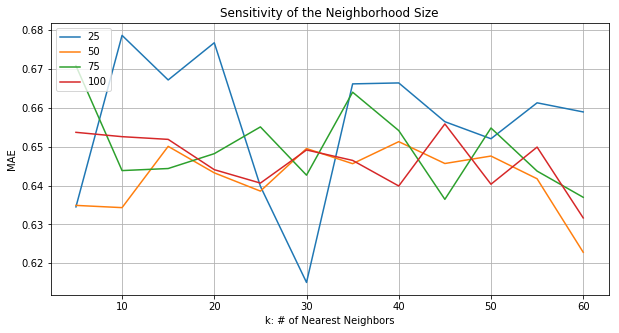

In [92]:
# reading the JSON data using json.load()
import json
import matplotlib.pyplot as plt

file = 'knnVsMae3.json'

with open(file) as knnVsMAE:
    file_knnVsMAE = json.load(knnVsMAE)

# converting json dataset from dictionary to dataframe
KMdf= pd.DataFrame.from_dict(file_knnVsMAE, orient='index')
KMdf= KMdf.reset_index(drop=False)
KMdf.columns = ['Sample_Size', 'k', 'MAE']
print KMdf

k = KMdf['k'][0]
Sample1MAE = KMdf['MAE'][0]
Sample2MAE = KMdf['MAE'][1]
Sample3MAE = KMdf['MAE'][2]
Sample4MAE = KMdf['MAE'][3]
#Creating the plot
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(k, Sample1MAE, k, Sample2MAE, k, Sample3MAE, k, Sample4MAE)
ax.set_ylabel('MAE')
ax.set_xlabel('k: # of Nearest Neighbors')

# Set the chart's title
ax.set_title('Sensitivity of the Neighborhood Size')
plt.legend(['25', '50', '75', '100'], loc = 'upper left', frameon=True)
# plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)
plt.grid()
plt.show()


  Sample_Size                                                f  \
0    10000,25  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
1    10000,50  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
2    10000,75  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   
3   10000,100  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]   

                                                 MAE  
0  [0.668118093349, 0.653867933978, 0.67810398664...  
1  [0.640103022421, 0.663900367675, 0.65241053087...  
2  [0.65145328128, 0.660040385099, 0.661070012906...  
3  [0.650252255878, 0.654387438279, 0.64347640689...  


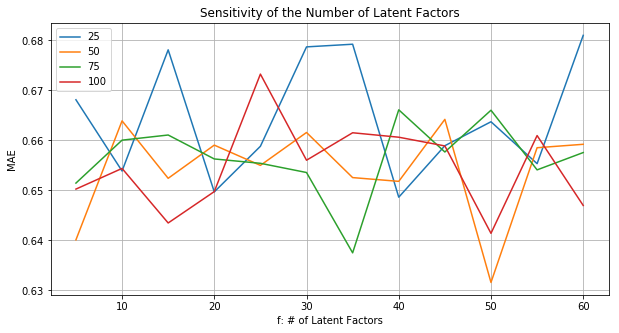

In [93]:
#MAE vs Latent Factors
file = 'mfsVsMae3.json'

with open(file) as mfsVsMAE:
    file_mfsVsMAE = json.load(mfsVsMAE)

# converting json dataset from dictionary to dataframe
MFSdf= pd.DataFrame.from_dict(file_mfsVsMAE, orient='index')
MFSdf= MFSdf.reset_index(drop=False)
MFSdf.columns = ['Sample_Size', 'f', 'MAE']
print MFSdf

f = MFSdf['f'][0]
Sample1MFS = MFSdf['MAE'][0]
Sample2MFS = MFSdf['MAE'][1]
Sample3MFS= MFSdf['MAE'][2]
Sample4MFS = MFSdf['MAE'][3]
# BaselineMAE = len(k)*[INSERT BASELINE MAE HERE]

#Creating the plot
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(f, Sample1MFS, f, Sample2MFS, f, Sample3MFS, f, Sample4MFS)
ax.set_ylabel('MAE')
ax.set_xlabel('f: # of Latent Factors')

# Set the chart's title
ax.set_title('Sensitivity of the Number of Latent Factors')
plt.legend(['25', '50', '75', '100'], loc = 'upper left', frameon=True)
# plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)
plt.grid()
plt.show()

The size of the neighborhood has significant impact on the prediction quality. So to determine the sensitivity of this parameter, we varied the number of neighbors used and observed its effect on MAE. Note that producting the actual output json files would take several hours so we've omitted it from this markdown file. We will be reading in json files containing the output of our offline runs. Our results are shown below for the item based model benchmarked against our baseline. Note that KNN for all sample sizes outperforms the benchmark baseline approach. The benchmark chosen had an average MAE across sample sizes of 0.8 while our model consistently performed at higher accuracy (lower MAE values). It is also interesting to note that as the neighborhood size increases from 0 to 15, the algorithms across all sample sizes increases in performance. However, once k increases past this threshold, we notice a decrease in accuracy performance. Therefore, 15 would be the optimal choice of neighborhood size when implementing this model for our business.

We also note that our largest sample size of 15000 users and 300 items outperforms (has a lower MAE) our other two samples of smaller sizes (with an exception at k = 45). However, since we stated earlier that for business purposes the ideal choice of k would be 15. Therefore, the slight underperformance of this larger sample size for k=45 can be disregarded. It's also interesting to note that the smallest sample size of 5000 users and 100 items outperforms the 10000 users and 200 items predictions until the threshold number of items = 25. A potential explanation that would need further review is that the errors with respect to k can resemble a bell curve -- as you increase k initially, you can be adding useful information from neighbors. However, past a certain threshold, you can potentially be weighing movies that are anti-correlated with your target movie. 

In general when the neighborhood size K is small, we're forcing our classifier to be "more blind" to the overall distribution. A small K will have low bias but higher variance. On the other hand, a higher K averages more voters in each prediction and is more resilient to outliers. This consequently results in lower variance but increased bias. 

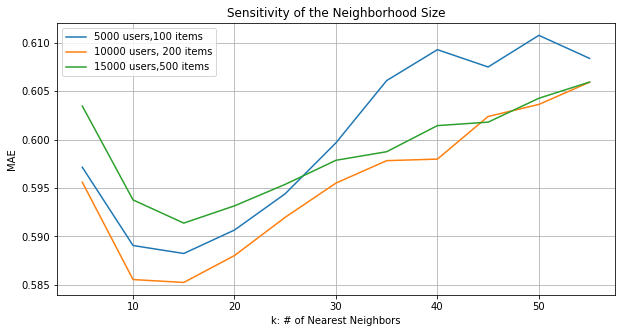

In [6]:
# reading the JSON data using json.load()
import json
import matplotlib.pyplot as plt
import pandas as pd 
file = 'knnVsMae.json'

with open(file) as knnVsMAE:
    file_knnVsMAE = json.load(knnVsMAE)

# converting json dataset from dictionary to dataframe
KMdf= pd.DataFrame.from_dict(file_knnVsMAE, orient='index')
KMdf= KMdf.reset_index(drop=False)
KMdf.columns = ['Sample_Size', 'k', 'MAE']

k = KMdf['k'][0]
Sample1MAE = KMdf['MAE'][0]
Sample2MAE = KMdf['MAE'][2]
Sample3MAE = KMdf['MAE'][1]

#Creating the plot

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(k, Sample1MAE, k, Sample2MAE, k, Sample3MAE)
ax.set_ylabel('MAE')
ax.set_xlabel('k: # of Nearest Neighbors')

# Set the chart's title
ax.set_title('Sensitivity of the Neighborhood Size')
plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)
plt.grid()
plt.show()

Similarity, the number of latent factors used for our matrix factorization impacts our prediction quality as well. We analyzed the sensitivity of this parameter. Note that larger sample sizes does indeed outperform the smallest sample size of (5000,100). And as the number of latent factors seems to be positively correlated with our model based algorithm's performance across all sample sizes (with slight fluctuations). Again our model outperformed the baseline model which had a MAE of 0.8.

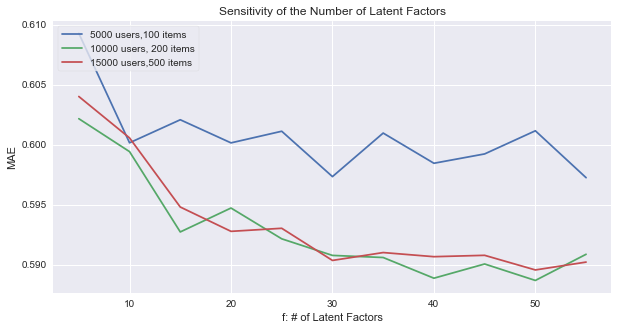

In [55]:
#MFS vs Latent Factors
file = 'mfsVsMae.json'

with open(file) as mfsVsMAE:
    file_mfsVsMAE = json.load(mfsVsMAE)

# converting json dataset from dictionary to dataframe
MFSdf= pd.DataFrame.from_dict(file_mfsVsMAE, orient='index')
MFSdf= MFSdf.reset_index(drop=False)
MFSdf.columns = ['Sample_Size', 'f', 'MAE']

f = MFSdf['f'][0]
Sample1MFS = MFSdf['MAE'][0]
Sample2MFS = MFSdf['MAE'][2]
Sample3MFS= MFSdf['MAE'][1]

#Creating the plot
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(f, Sample1MFS, f, Sample2MFS, f, Sample3MFS)
ax.set_ylabel('MAE')
ax.set_xlabel('f: # of Latent Factors')

# Set the chart's title
ax.set_title('Sensitivity of the Number of Latent Factors')
plt.legend(['5000 users,100 items', '10000 users, 200 items', '15000 users,500 items'],loc='upper left', frameon=True)

plt.show()

Lastly, we'd like to compare the accuracy of the item based CF algorithm to the baseline and Matrix Factorized (model based) model across various number of items. Our results are shown below. For every variation of item size in the model, matrix factorization is less accurate than our item based KNN approach. Interestingly enough, there seems to be a slight decrease in accuracy of both models as model accommodates more items.

   m_items model       mae
0      100    mf  0.602074
1      100   knn  0.588247
2      200    mf  0.592730
3      200   knn  0.585261
4      500    mf  0.594805
5      500   knn  0.591382


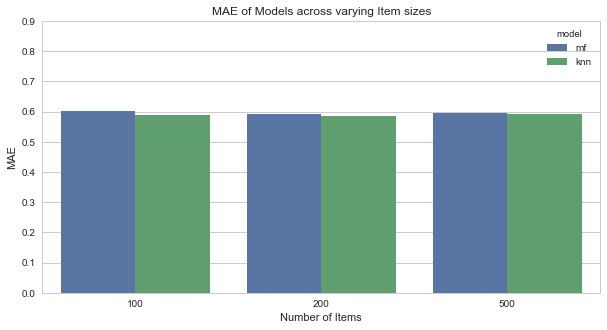

In [51]:
#MAE of Models across Item Sizes
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")

itemMAEdf = pd.read_csv('item_size_vs_MAE.csv', sep = ',')
print itemMAEdf

fig, ax = plt.subplots(figsize=(10,5))

g1 = sns.barplot(x='m_items', y = 'mae', hue = 'model', data = itemMAEdf)
ylist = [.1*x for x in range(10)]
g1.set(yticks=ylist)

plt.ylabel('MAE')
plt.xlabel('Number of Items')
plt.title('MAE of Models across varying Item sizes')

plt.show(g1);



## (iii) Coverage on training and test data
	We used catalog coverage to see how well we were recommending all of the items in our movie catalog. It was 1.0 for small numbers of items (100), and was around 60% for larger datasets. In general we covered the most popular movies well, but didn't get a lot of the long tail once our item set increased. If we wanted to cover more items (potentially at the cost of accuracy) we could give additional weight to less rated items. This will increase novelty for our users, potentially at the risk of recommending movies they are less likely to enjoy. 
    

### Model Size Variation

As mentioned earlier, intuitively we'd expect the runtime of both algorithms to increase as our model size increases. The figure below validates this intuition and compares the runtime of our Item Based model against its model based counterpart. As you can see by the plot below, for smaller model sizes, item based CF algorithms actually perform faster than the Matrix Factorization counterpart. However, as the model size increases (number of items increases), matrix factorization methods perform significantly faster. 

   m_items model        time
0      100    mf   85.533649
1      100   knn   50.345455
2      200    mf  214.998407
3      200   knn  215.804478
4      500    mf  649.834471
5      500   knn  908.245904


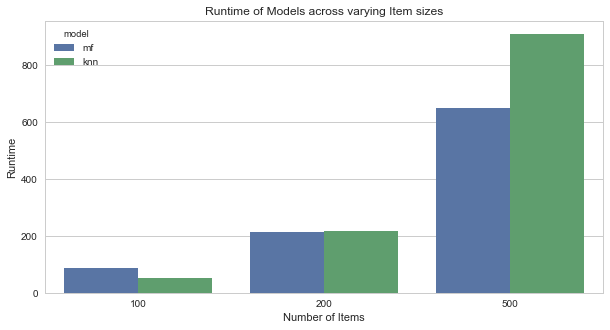

In [52]:
#MAE vs Neighborhood size

itemtimedf = pd.read_csv('item_size_vs_time.csv', sep = ',')
print itemtimedf

fig, ax = plt.subplots(figsize=(10,5))

g2 = sns.barplot(x='m_items', y = 'time', hue = 'model', data = itemtimedf)
ylist = [.1*x for x in range(10)]
g1.set(yticks=ylist)

plt.ylabel('Runtime')
plt.xlabel('Number of Items')
plt.title('Runtime of Models across varying Item sizes')
sns.set()
plt.show(g2)



The hypothetical objective of this case study was to see if both the item-based collaborative filtering algorithm and the model-based algorithm could accurately predict the top-5 movies for a given user (and perform better than a baseline model). Both models achieved this objective, however the nearest-neighbors model achieved a lower MAE than the matrix factorization model. Even though the matrix factorization model took less time to compute, the nearest-neighbor algorithm had a lower error rate and  presumably in a company there would be faster processors that could handle this magnitude of processing with ease, and thus this problem would be less important. We would feel somewhat comfortable putting these solutions into production at a company since it outperforms the baseline model, but we think that this algorithm should be improved to incorporate variables such as genre. Potential watch-outs include keeping an eye on the balance between variance and bias in the nearest neighbors method as well as the slow down as model size increases.